In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.421156  0.172446 -0.938967 -0.510473 -0.372770  0.414235 -0.426101   
  1   0.328920  1.077858 -0.102097 -0.259035  1.300275  0.461575  0.170730   
  2  -0.446565  1.039473  0.538733 -1.030563 -0.525560 -0.513190 -0.721114   
  3   0.774127  0.442909 -0.055861  0.774289  0.232507 -0.499671 -0.323105   
  4   0.367155  0.511626  0.328912  0.182202 -0.459801  0.098825 -0.953522   
  5  -0.103885  0.702128 -0.051066 -0.844913 -0.487474  0.116474 -0.176593   
  6   0.535127  1.933740 -0.164393  0.110523 -0.525123  0.291761  0.310183   
  7   0.147631  0.387797  0.158506  0.085040  0.479583  0.375344 -0.721026   
  8   0.214511  0.583009 -0.498726  0.390413  0.197539 -0.033594 -0.989505   
  9  -1.078030  1.588024 -0.396222  0.874428 -0.495236 -1.367023 -0.292473   
  10  0.847464  1.431962  0.194899 -0.310906 -0.338204  0.375048 -0.470784   
  11 -0.313982 -0.839820 -1.072777 -0.725102  0.303668 -0.535667 -0.713625   
  12  0.758157  0.273516 -1.076312 -0.167273  0.478800  0.039518  0.220622   
  13 -0.330798  0.390203 -0.628845  0.240061 -0.100200 -0.979213  0.031350   
  14  1.086695  0.419853 -0.018400 -0.037831 -0.580887 -0.058574  0.194855   
  15 -0.179721  0.958690 -0.159810  0.066673 -0.704170  0.219321 -0.220929   
  16 -0.141049  0.716843 -0.795115 -0.284714  0.262420  0.390402 -0.381522   
  17  0.058807  0.206932  0.323951 -0.513518  0.416429  0.081845 -0.847982   
  18  0.357325  0.603784 -0.027991 -0.187054  0.400448  0.068595  0.275582   
  19  0.965479  0.984820  0.819197 -0.407299 -0.678641  0.147746  0.021730   
  20 -0.340247  0.947258 -0.470332 -1.031847 -0.002893 -0.090234 -0.301101   
  21 -0.889828  0.388912  0.019934  0.197078 -0.899100 -0.239413  0.481977   
  22  0.653442 -0.057659 -1.235752  0.306436 -0.306619 -0.058899 -0.884810   
  23 -0.091640  0.546930 -1.489682 -1.136325 -0.560893  0.424476 -0.806869   
  24  0.406937  0.988314  0.214899  0.304664 -0.281051 -0.531832  0.080946   
1 0   0.547934  0.394201 -0.555527 -0.913939 -0.213966  0.319525 -0.437931   
  1   0.126029  1.038384  0.996740  0.902967  0.465268 -0.005883 -0.270113   
  2  -0.146648  0.920709  0.366914 -0.088786 -0.332482 -0.242839  0.119135   
  3   0.576657 -0.289800  0.448626  0.872654 -0.910920 -0.411797 -0.421856   
  4   0.514576  1.213653 -1.211718 -0.863550  0.046291  0.093875 -0.382775   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.675477  1.252684  0.967073  ...  0.169333  0.398038 -0.458336   
  1   0.058770  1.048785  0.296428  ... -0.496527  0.982586 -0.183771   
  2   0.043350 -0.443814  0.972867  ...  0.045793 -0.224812 -0.271307   
  3   1.316538  0.004716  0.776242  ... -0.132352 -0.343848 -0.438730   
  4  -0.201870  0.359641  0.014555  ... -0.607761 -0.083185  0.932121   
  5  -0.127673  0.206541  0.666073  ...  0.469324 -0.589497  0.100271   
  6  -0.542997  0.062880  0.785562  ... -0.790242 -0.332354  0.786948   
  7   0.165640 -0.413155 -0.099872  ... -0.225797  0.701505 -0.095877   
  8   0.560432  0.570599  1.797900  ... -0.540661  0.484607  0.492632   
  9   1.047117  0.806446  0.162122  ... -1.026788  0.387663 -1.000005   
  10  0.768553  0.611023  0.618418  ... -0.779340  0.250993 -0.544343   
  11 -1.060576 -0.838534 -0.352641  ... -0.903747  1.393176 -0.377831   
  12 -0.103200 -0.010174  0.363468  ... -0.234977  1.053141  0.637732   
  13  0.277243  0.553418  0.486726  ... -0.426099  0.842024 -0.116066   
  14 -0.322655  0.493256  0.025864  ... -0.115162  0.104865  0.598914   
  15  0.446995  0.457717  0.737985  ...  0.043916  0.184591  0.265672   
  16 -0.114356 -0.106299 -0.156635  ...  0.014757 -0.723347  0.314493   
  17  0.587094  0.769082  1.189236  ... -0.071557  0.755013  1.056563   
  18 -0.918381 -0.619842 -0.787210  ...  0.257936  0.520727 -0.049140   
  19  0.687153  0.029710  0.704332  ...  0.325211  0.483813  1.231375   
  20  0.107714  0.053801 -0.130975  ... -0.258088 -0.229479 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err         t          P>|t|   2.5 %    97.5 %
D  1.122407  0.045719  24.55018  4.305887e-133  1.0328  1.212015


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



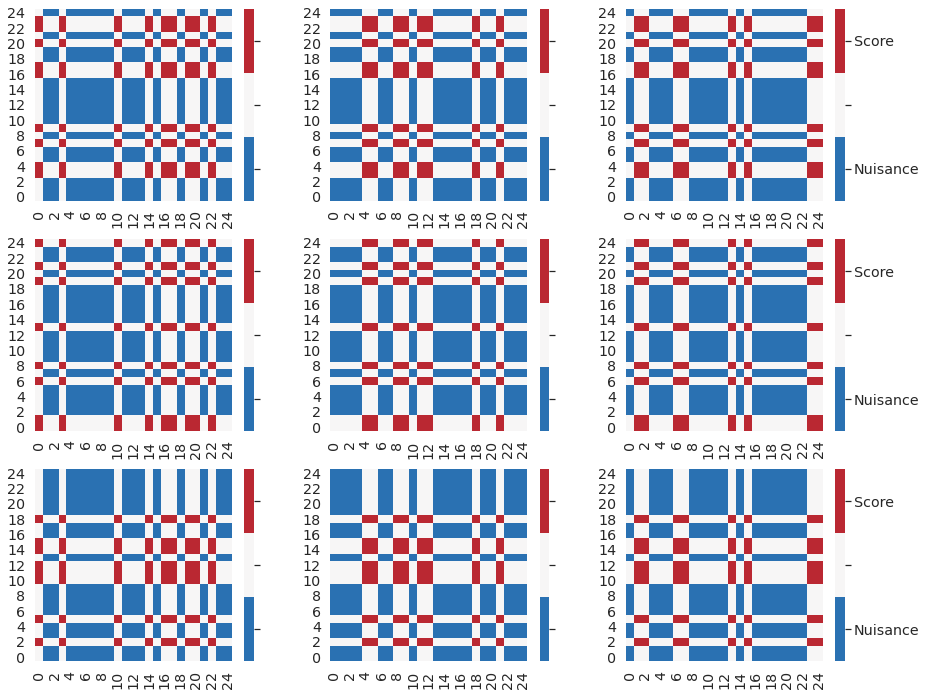

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



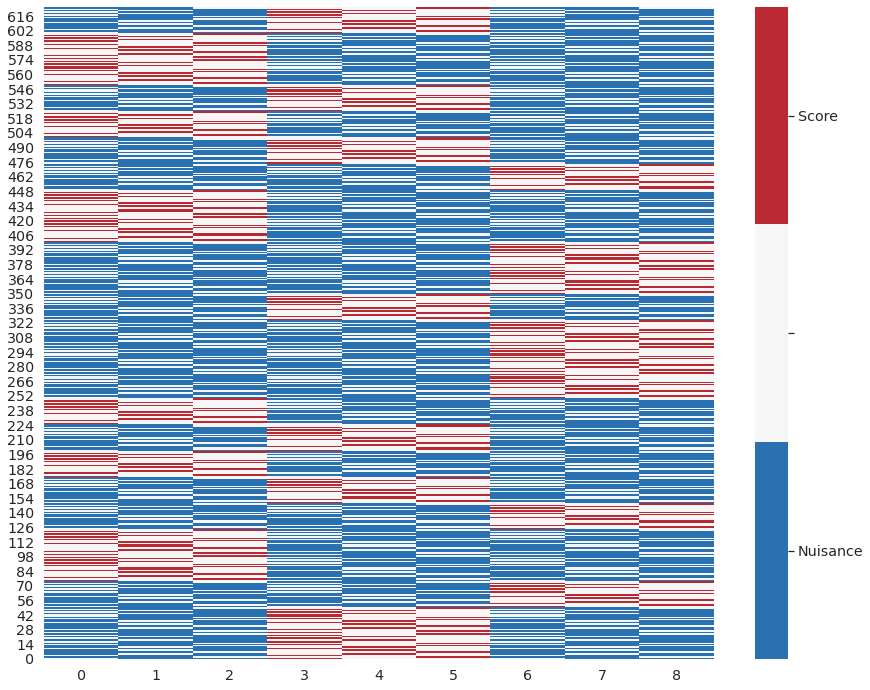

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])